# Create Data

In [1]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

# Remove stop words


In [2]:
def remove_stop_words(corpus):
    stop_words = ['the','is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [3]:
corpus = remove_stop_words(corpus)


In [4]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

Here is our word set without stopword by which we will create word vector



In [5]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

# Data generation
we will generate label for each word using skip gram.



In [6]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i
    
word2int

{'queen': 0,
 'wise': 1,
 'princess': 2,
 'pretty': 3,
 'young': 4,
 'king': 5,
 'man': 6,
 'woman': 7,
 'boy': 8,
 'prince': 9,
 'girl': 10,
 'strong': 11}

In [7]:
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
sentences    

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

we will generate label for each word using skip gram.


In [8]:
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [9]:
data

[['king', 'strong'],
 ['king', 'man'],
 ['strong', 'king'],
 ['strong', 'man'],
 ['man', 'king'],
 ['man', 'strong'],
 ['queen', 'wise'],
 ['queen', 'woman'],
 ['wise', 'queen'],
 ['wise', 'woman'],
 ['woman', 'queen'],
 ['woman', 'wise'],
 ['boy', 'young'],
 ['boy', 'man'],
 ['young', 'boy'],
 ['young', 'man'],
 ['man', 'boy'],
 ['man', 'young'],
 ['girl', 'young'],
 ['girl', 'woman'],
 ['young', 'girl'],
 ['young', 'woman'],
 ['woman', 'girl'],
 ['woman', 'young'],
 ['prince', 'young'],
 ['prince', 'king'],
 ['young', 'prince'],
 ['young', 'king'],
 ['king', 'prince'],
 ['king', 'young'],
 ['princess', 'young'],
 ['princess', 'queen'],
 ['young', 'princess'],
 ['young', 'queen'],
 ['queen', 'princess'],
 ['queen', 'young'],
 ['man', 'strong'],
 ['strong', 'man'],
 ['woman', 'pretty'],
 ['pretty', 'woman'],
 ['prince', 'boy'],
 ['prince', 'king'],
 ['boy', 'prince'],
 ['boy', 'king'],
 ['king', 'prince'],
 ['king', 'boy'],
 ['princess', 'girl'],
 ['princess', 'queen'],
 ['girl', 'prin

In [10]:
import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [11]:
df.head()

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king


# Let' Tensorflow Graph


In [20]:
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

print(tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
2.0.0


### One_hot_encoding

In [21]:
ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

### Train

In [22]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  2.8559747
iteration 3000 loss is :  1.8328941
iteration 6000 loss is :  1.7896621
iteration 9000 loss is :  1.7641538
iteration 12000 loss is :  1.7482015
iteration 15000 loss is :  1.7366886
iteration 18000 loss is :  1.7277782


In [23]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)


[[-1.0304193   0.02853282]
 [-5.1922135   0.46124512]
 [-4.5537996   1.3996869 ]
 [-0.6345462  -2.955978  ]
 [-0.04800637 -0.02207999]
 [ 0.52128106  0.9047789 ]
 [ 0.8020196   0.85815316]
 [-1.3452852   0.53878844]
 [ 0.66092813  2.271018  ]
 [ 1.4377288   2.7174768 ]
 [-2.193031    0.2366792 ]
 [ 2.2567136   5.500833  ]]


### word vector in table


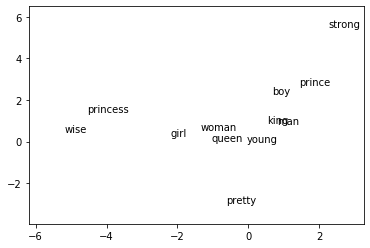

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()